# Introduction

This is the most basic run of PARCELS relevant to my project to quantify dispersal between hydrothermal vents

![PARCELS data structure](https://oceanparcels.org/images/parcelsdesign_minimal.png)

In [1]:
#Import packages
import netCDF4
from netCDF4 import Dataset,num2date 
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, AdvectionDiffusionM1, ErrorCode, ParcelsRandom, Variable, VectorField, DiffusionUniformKh, plotTrajectoriesFile
import numpy as np
import math
from datetime import datetime
from datetime import timedelta
from operator import attrgetter
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import itertools
import random

import cftime
#import cartopy.crs as ccrs
#import cartopy.feature as cfeatureinstall 

#Addition
import sys
import subprocess
from glob import glob



In [3]:
__version__ parcels

SyntaxError: invalid syntax (<ipython-input-3-5eaf3d282fd4>, line 1)

# Create a fieldset from HYCOM netcdf

## Check the velocity data

In [7]:
#Input the directory where your data is stored
!ls OGCM_Otis/GLBu0.08_expt_19.1nwp_surf*

OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-01T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-02T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-03T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-04T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-05T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-06T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-07T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-08T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-09T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-10T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-11T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-12T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-13T00:00:00.000000000_UV.nc
OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-14T00:

In [8]:
#Check an example
eg = xr.open_dataset('OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_2012-01-24T00:00:00.000000000_UV.nc')
eg

<xarray.Dataset>
Dimensions:     (lat: 351, lon: 401)
Coordinates:
    depth       float64 ...
  * lat         (lat) float64 10.0 10.08 10.16 10.24 ... 37.76 37.84 37.92 38.0
  * lon         (lon) float64 118.0 118.1 118.2 118.2 ... 149.8 149.9 150.0
    time        datetime64[ns] ...
Data variables:
    water_u     (lat, lon) float32 ...
    water_v     (lat, lon) float32 ...
    water_temp  (lat, lon) float32 ...
    surf_el     (lat, lon) float32 ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file
    history:                   archv2ncdf3z
    field_type:                instantaneous
    Conventions:               CF-1.0 NAVO_netcdf_v1.0

## Designate the netcdf file(s) that will act as the fieldset

In [9]:
files = sorted(glob('OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_*'))
len(files)

366

In [10]:
timestamps = np.expand_dims(np.arange(np.datetime64('2012-01-01'), np.datetime64('2013-01-01')),axis=1)


len(timestamps)

366

In [20]:
timestamps

array([['2012-01-01'],
       ['2012-01-02'],
       ['2012-01-03'],
       ['2012-01-04'],
       ['2012-01-05'],
       ['2012-01-06'],
       ['2012-01-07'],
       ['2012-01-08'],
       ['2012-01-09'],
       ['2012-01-10'],
       ['2012-01-11'],
       ['2012-01-12'],
       ['2012-01-13'],
       ['2012-01-14'],
       ['2012-01-15'],
       ['2012-01-16'],
       ['2012-01-17'],
       ['2012-01-18'],
       ['2012-01-19'],
       ['2012-01-20'],
       ['2012-01-21'],
       ['2012-01-22'],
       ['2012-01-23'],
       ['2012-01-24'],
       ['2012-01-25'],
       ['2012-01-26'],
       ['2012-01-27'],
       ['2012-01-28'],
       ['2012-01-29'],
       ['2012-01-30'],
       ['2012-01-31'],
       ['2012-02-01'],
       ['2012-02-02'],
       ['2012-02-03'],
       ['2012-02-04'],
       ['2012-02-05'],
       ['2012-02-06'],
       ['2012-02-07'],
       ['2012-02-08'],
       ['2012-02-09'],
       ['2012-02-10'],
       ['2012-02-11'],
       ['2012-02-12'],
       ['20

In [11]:
filenames = {'U': 'OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_*.nc',
             'V': 'OGCM_Otis/GLBu0.08_expt_19.1nwp_surf_*.nc'}
print(len(filenames))

# Specify the varaibles and dimensions within those files 
# this information can be found in the description of the HYCOM above.

variables = {'U': 'water_u',
             'V': 'water_v'}
dimensions = {'lat': 'lat',
              'lon': 'lon'}

#setting vmin designates HYCOM land cells (<-2000) as 0
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, vmin=-2000,timestamps = timestamps) 

#fieldset.U.show()


2


## Create Particle set to release in fieldset

In [13]:
npart = 100  # number of particles to be released
lon = np.linspace(125, 126, npart, dtype=np.float32)
lat = 25.1* np.ones(npart)
dep = 1452.251 * np.ones(npart)
time = np.zeros(npart)


pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, depth = dep, time=time)


In [18]:
#A kernel that  deletes a particle (solution to error messages)
def DeleteParticle(particle, fieldset, time):
    particle.delete()

## Execute PARCELS!

In [21]:

output_file = pset.ParticleFile(name="insertname_particles.nc", outputdt= timedelta(days=1)) # the file name and the time step of the outputs [I had issues with the 'timedelta' so i just changed it to a positive double (1)]
pset.execute(AdvectionRK4,                 # the kernel (which defines how particles move)
             runtime= timedelta(days=100),    # the total length of the run
             dt= timedelta(hours=1),
             recovery ={ErrorCode.ErrorOutOfBounds: DeleteParticle, 
                        ErrorCode.ErrorInterpolation: DeleteParticle},# How to handle error messages# the timestep of the kernel
             output_file=output_file)

In [22]:
output_file.export()


# Default plotting does not work in DEIGO

/Users/otisbrunner/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


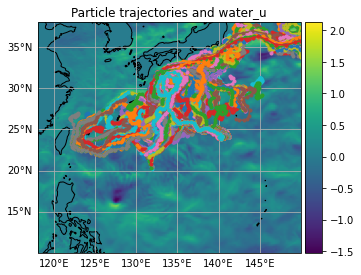

In [18]:
#plotTrajectoriesFile('insertname_particles.nc',
#                     tracerfile='nwp_surf_2012-08-13.nc',
#                     tracerlon='lon',
#                     tracerlat='lat',
#                     tracerfield='water_u');

In [19]:
#
#plotTrajectoriesFile('insertname_particles.nc', mode = 'movie2d_notebook', movie_forward=True, show_plt =True,
#                     tracerfile='nwp_surf_2012-08-13.nc',
#                     tracerlon='lon',
#                     tracerlat='lat',
#                     tracerfield='water_u')

Populating the interactive namespace from numpy and matplotlib


/Users/otisbrunner/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/parcels/scripts/plottrajectoriesfile.py:92: RuntimeWarning: invalid value encountered in remainder
  ax.set_xlim(np.nanmin((lon+central_longitude+180) % 360 - 180), np.nanmax((lon+central_longitude+180) % 360 - 180))


**Plot the density distribution** of particles as a histogram overlaying the map. Customiseable using parameters from the 'matplotlib.pyplot.hist2d' function

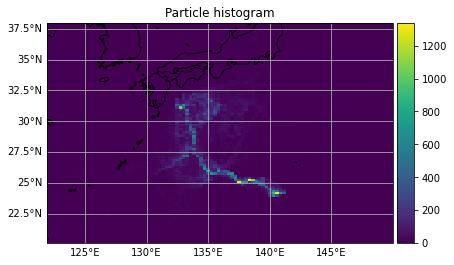

In [20]:

#plotTrajectoriesFile('insertname_particles.nc', mode='hist2d', bins=[100, 100]);

The above plots are informative but lack customization options. In the next tutorial we will analyse and plot data taken from the particle trajector output file

## Analyse Trajectory Output 


In [2]:

import xarray as xr

ptcls = xr.open_dataset('insertname_particles.nc')
ptcls

<xarray.Dataset>
Dimensions:     (traj: 100, obs: 101)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           spherical

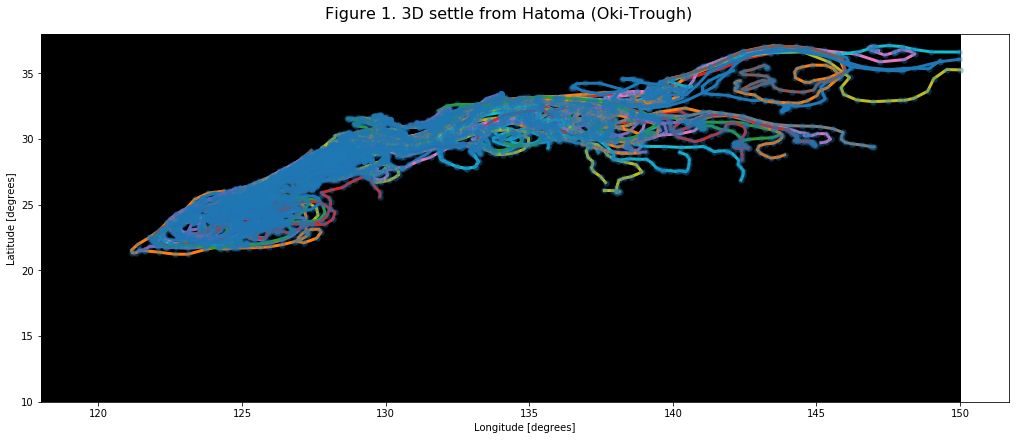

In [5]:
fig,(ax1) = plt.subplots(1,figsize=(14,6),constrained_layout=True)
fig.suptitle('Figure 1. 3D settle from Hatoma (Oki-Trough)', fontsize=16)

ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
#ax1.set_xlim(xmin, xmax)
#ax1.set_ylim(ymin, ymax)


v_velocity =ax1.pcolormesh(eg['lon'],eg['lat'],eg['water_v'],edgecolors='k',linewidth=1)

ax1.plot(ptcls['lon'].T, ptcls['lat'].T,linewidth=3,zorder=1)
ax1.scatter(ptcls['lon'], ptcls['lat'], s=30, cmap='viridis_r', alpha=0.3, zorder=2, label = ptcls['trajectory'][0])





plt.show()